Dataset Shape: (1966, 8)
Columns: ['author', 'published', 'title', 'text', 'language', 'label', 'title_without_stopwords', 'text_without_stopwords']
First few rows:


,author,published,title,text,language,label,title_without_stopwords,text_without_stopwords
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...


Label distribution:
label
0    0.619023
1    0.380977
Name: proportion, dtype: float64


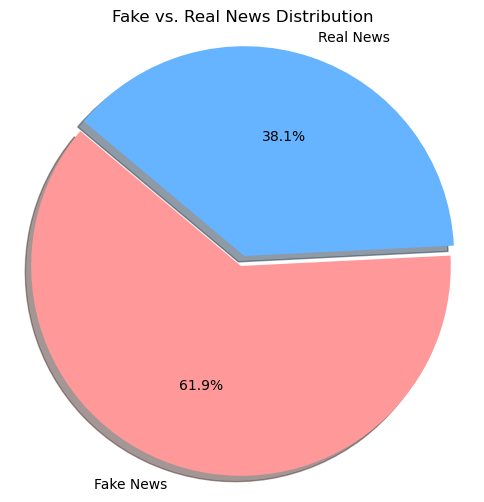

In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer

# For data splitting and balancing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Step 2: Load the cleaned dataset
file_path = 'news_articles-1.xlsx'  # If in same directory as your notebook
df = pd.read_excel(file_path)

# Step 3: Quick check
print(f"Dataset Shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("First few rows:")
display(df.head())
# Step 4: Prepare feature (X) and label (y)
X = df['text_without_stopwords']
y = df['label'].map({'Fake': 0, 'Real': 1})  # Convert labels to binary: 0 = Fake, 1 = Real

# Check class balance
print("Label distribution:")
print(y.value_counts(normalize=True))
# Step 5: Pie chart to show label distribution
import matplotlib.pyplot as plt

# Count label frequencies
label_counts = y.value_counts()
labels = ['Fake News', 'Real News']
sizes = label_counts.values
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  # Slightly "explode" the first slice (Fake News)

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Fake vs. Real News Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


,Model,Test Size,Accuracy,Precision,Recall,F1 Score,Lowercase,Stop Words,Min DF,N-Gram Range,Max Features
0,Decision Tree,0.2,0.6371,0.5207,0.5867,0.5517,True,english,5,"(1, 1)",1000
1,Decision Tree,0.3,0.6695,0.5670,0.5644,0.5657,True,english,10,"(1, 2)",3000
2,Decision Tree,0.4,0.6798,0.5805,0.5767,0.5786,True,english,15,"(1, 3)",2000
6,Multinomial NB,0.2,0.6904,0.7000,0.3267,0.4455,True,english,5,"(1, 1)",1000
7,Multinomial NB,0.3,0.7034,0.7404,0.3422,0.4681,True,english,10,"(1, 2)",3000
8,Multinomial NB,0.4,0.7052,0.7179,0.3733,0.4912,True,english,15,"(1, 3)",2000
3,k-NN,0.2,0.6472,0.7037,0.1267,0.2147,True,english,5,"(1, 1)",1000
4,k-NN,0.3,0.6424,0.8889,0.0711,0.1317,True,english,10,"(1, 2)",3000
5,k-NN,0.4,0.6404,0.8696,0.0667,0.1238,True,english,15,"(1, 3)",2000


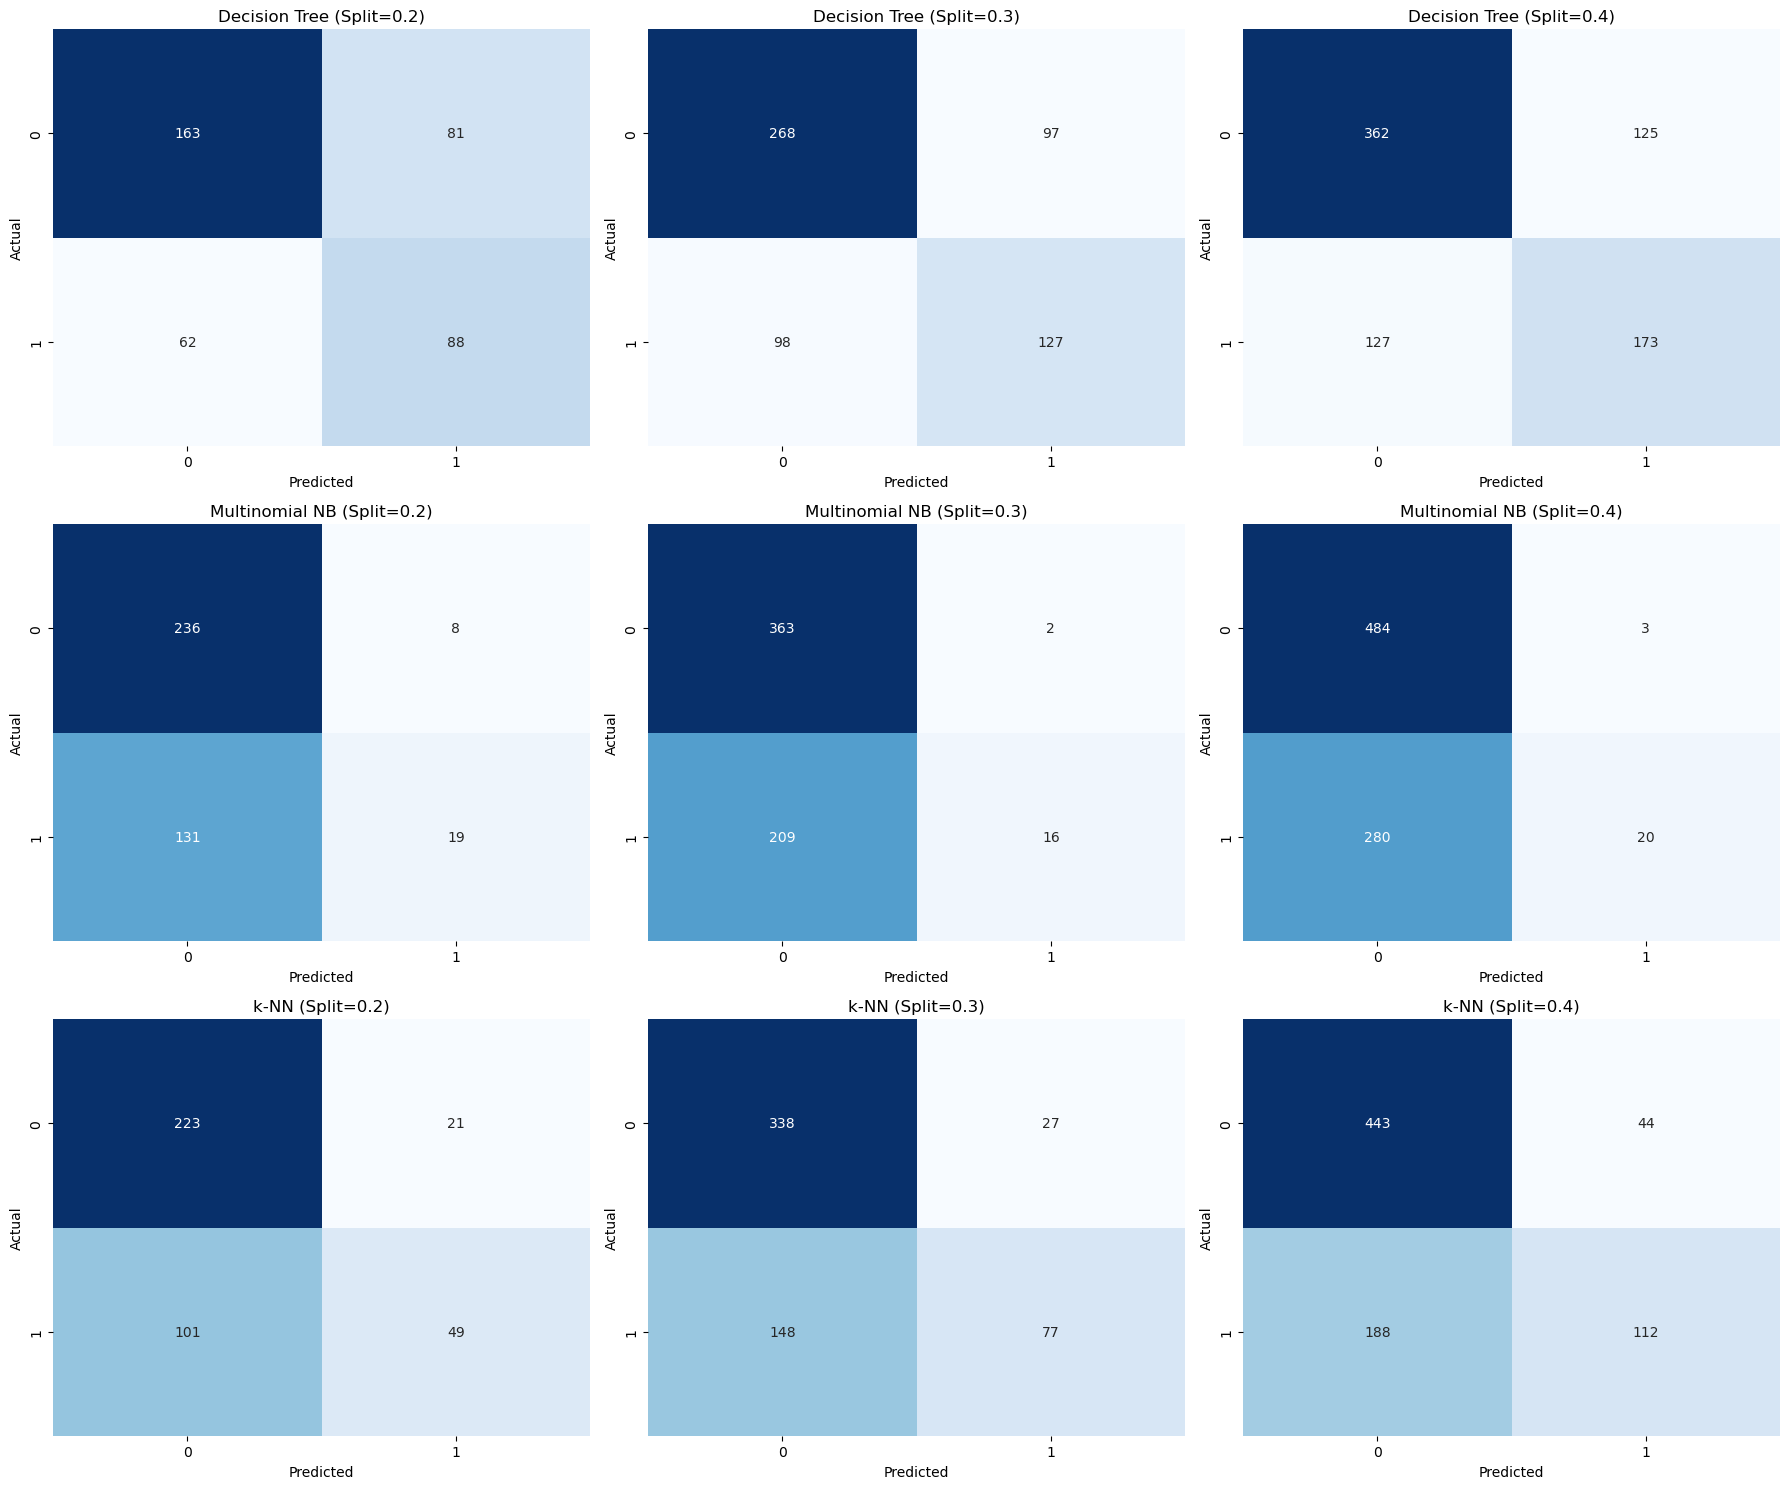

In [4]:
# =========================
# 1. Controlled Experiment Runner (with Confusion Matrix)
# =========================

from sklearn.metrics import confusion_matrix

def run_single_experiment(model_name, test_size, ngram_range, min_df, max_features):
    lowercase = True
    stop_words = 'english'
    
    # Set up TF-IDF
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=lowercase,
        stop_words=stop_words,
        min_df=min_df,
        ngram_range=ngram_range,
        max_features=max_features
    )
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Select model
    if model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'k-NN':
        model = KNeighborsClassifier()
    elif model_name == 'Multinomial NB':
        model = MultinomialNB()
    else:
        raise ValueError(f"Unknown model {model_name}")
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'Lowercase': lowercase,
        'Stop Words': stop_words,
        'Min DF': min_df,
        'N-Gram Range': ngram_range,
        'Max Features': max_features,
        'Confusion Matrix': cm  # <== Save confusion matrix here
    }

# =========================
# 2. Define Experiments
# =========================

experiment_plan = [
    # Decision Tree
    ('Decision Tree', 0.2, (1,1), 5, 1000),
    ('Decision Tree', 0.3, (1,2), 10, 3000),
    ('Decision Tree', 0.4, (1,3), 15, 2000),
    
    # k-NN
    ('k-NN', 0.2, (1,1), 5, 1000),
    ('k-NN', 0.3, (1,2), 10, 3000),
    ('k-NN', 0.4, (1,3), 15, 2000),
    
    # Multinomial NB
    ('Multinomial NB', 0.2, (1,1), 5, 1000),
    ('Multinomial NB', 0.3, (1,2), 10, 3000),
    ('Multinomial NB', 0.4, (1,3), 15, 2000)
]

# =========================
# 3. Run Experiments
# =========================

results = []

for model_name, test_size, ngram_range, min_df, max_features in experiment_plan:
    result = run_single_experiment(
        model_name, test_size, ngram_range, min_df, max_features
    )
    results.append(result)

# =========================
# 4. Display Final Results
# =========================

import pandas as pd

# Separate confusion matrices
confusion_matrices = [res.pop('Confusion Matrix') for res in results]

controlled_results_df = pd.DataFrame(results)
controlled_results_df = controlled_results_df.sort_values(by=['Model', 'Test Size'])

display(controlled_results_df)

# =========================
# 5. Plot Confusion Matrices
# =========================

import matplotlib.pyplot as plt
import seaborn as sns

# Quick plot all confusion matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 9 plots (3x3)

for idx, cm in enumerate(confusion_matrices):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f"{controlled_results_df.iloc[idx]['Model']} (Split={controlled_results_df.iloc[idx]['Test Size']})")

plt.tight_layout()
plt.show()



,Model,Test Size,Accuracy,Precision,Recall,F1 Score,Min DF,N-Gram Range,Max Features
0,Decision Tree,0.2,0.6904,0.5875,0.6267,0.6065,5,"(1, 1)",1000
1,Decision Tree,0.3,0.6729,0.5702,0.5778,0.5740,10,"(1, 2)",3000
2,Decision Tree,0.4,0.6836,0.5847,0.5867,0.5857,15,"(1, 3)",2000
6,Multinomial NB,0.2,0.6599,0.5460,0.6333,0.5864,5,"(1, 1)",1000
7,Multinomial NB,0.3,0.6763,0.5654,0.6533,0.6062,10,"(1, 2)",3000
8,Multinomial NB,0.4,0.6671,0.5487,0.7133,0.6203,15,"(1, 3)",2000
3,k-NN,0.2,0.4162,0.3913,0.9600,0.5560,5,"(1, 1)",1000
4,k-NN,0.3,0.5780,0.4592,0.6000,0.5202,10,"(1, 2)",3000
5,k-NN,0.4,0.4384,0.4003,0.9500,0.5632,15,"(1, 3)",2000


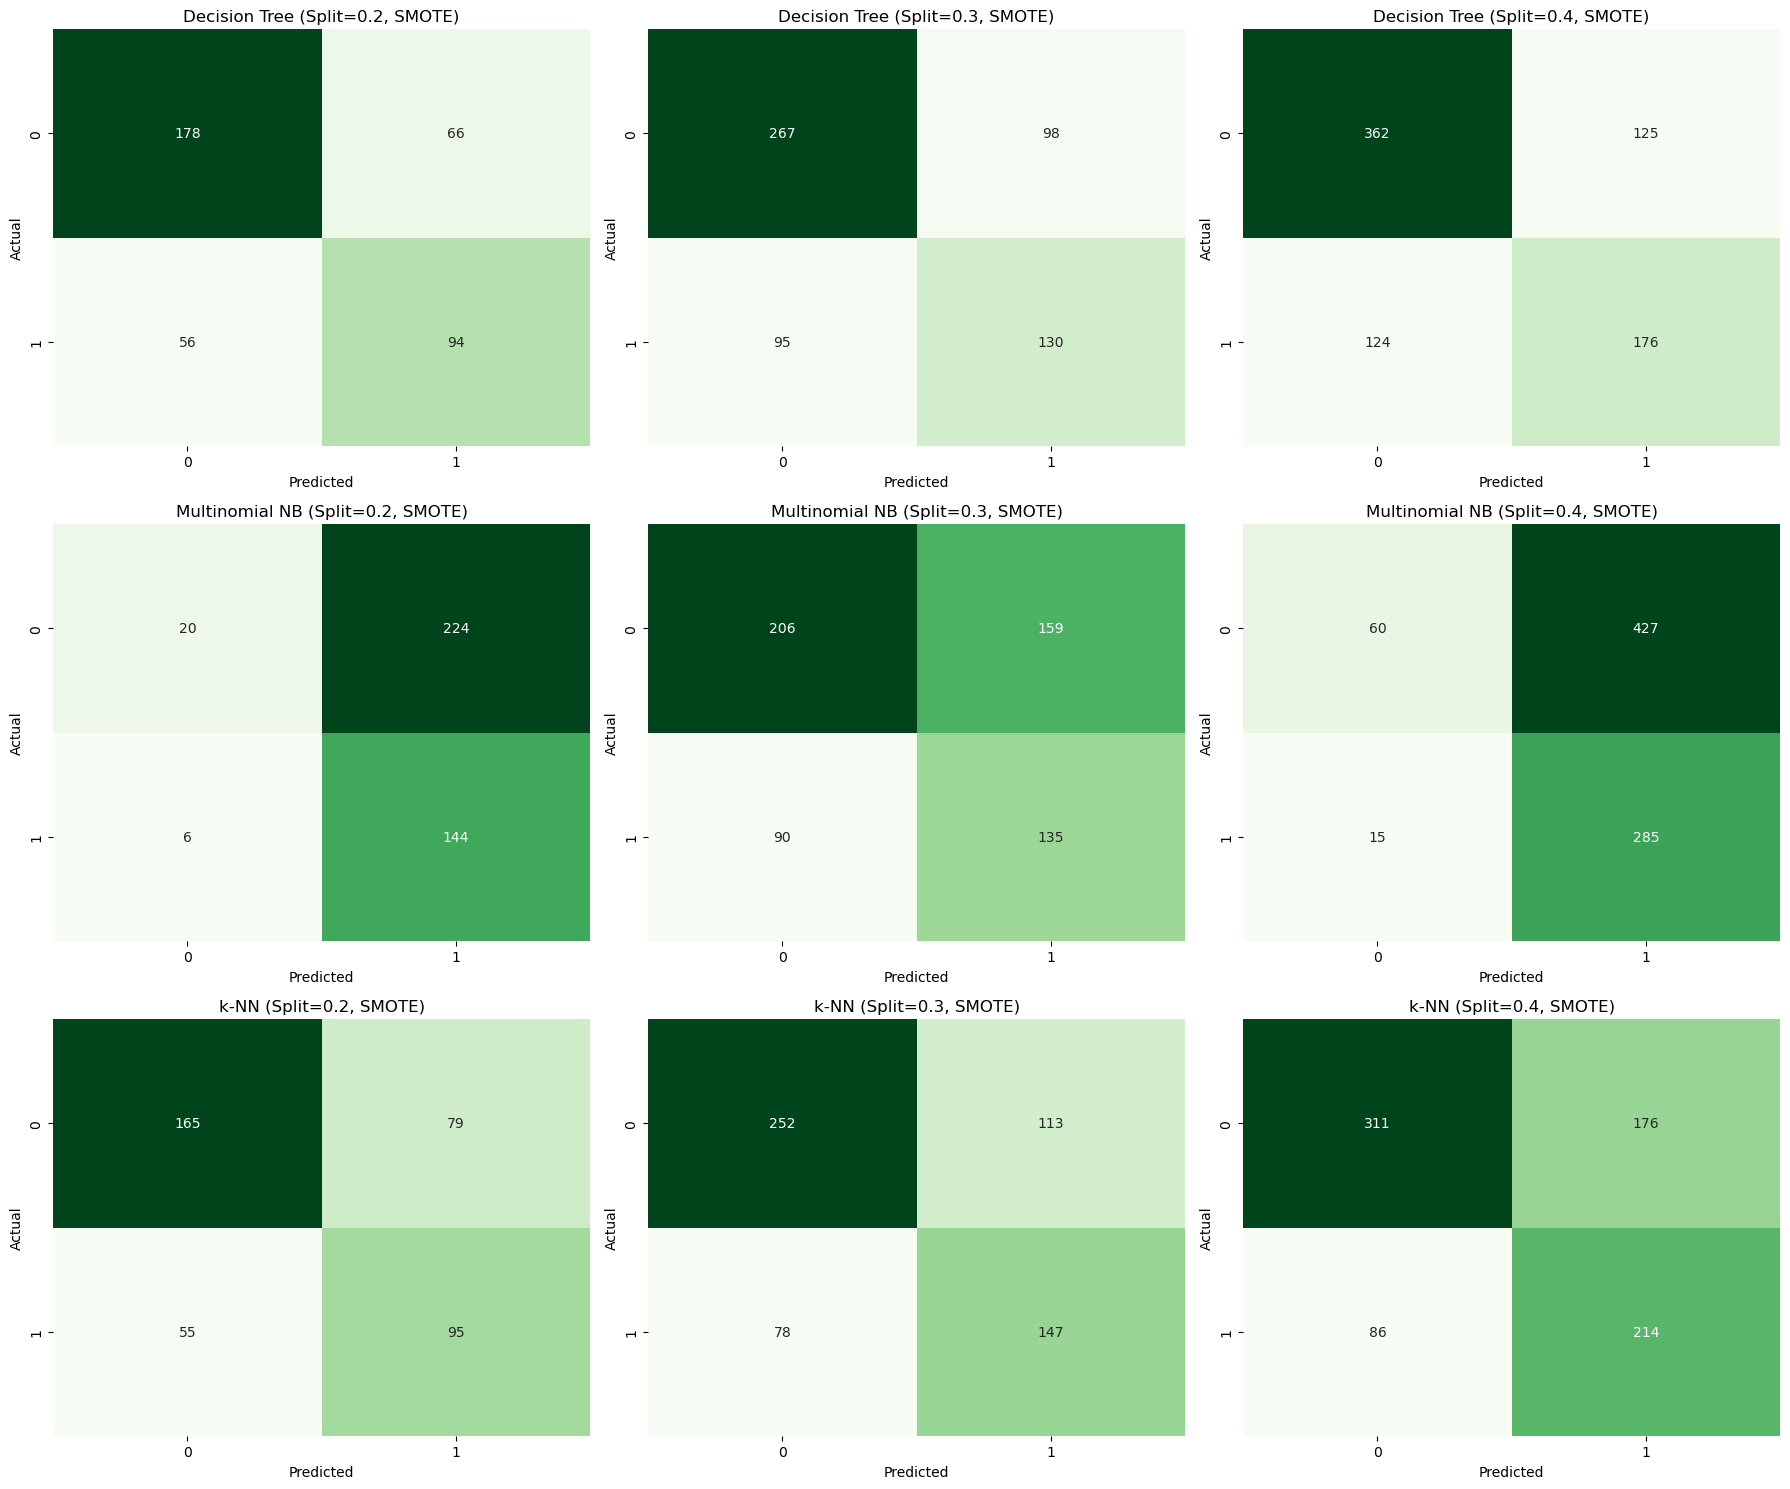

In [8]:
# ===========================================
# 1. Prepare Data
# ===========================================
X = df['text_without_stopwords'].astype(str)
y = df['label'].map({'Fake': 0, 'Real': 1})

# ===========================================
# 2. SMOTE Experiment Runner
# ===========================================
def run_smote_experiment(model_name, test_size, ngram_range, min_df, max_features):
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        min_df=min_df,
        ngram_range=ngram_range,
        max_features=max_features
    )
    X_tfidf = tfidf_vectorizer.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=42, stratify=y
    )

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Select model
    if model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'k-NN':
        model = KNeighborsClassifier()
    elif model_name == 'Multinomial NB':
        model = MultinomialNB()
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Train and predict
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'Min DF': min_df,
        'N-Gram Range': ngram_range,
        'Max Features': max_features,
        'Confusion Matrix': cm
    }

# ===========================================
# 3. Define Experiment Plan (No 0.5 Splits)
# ===========================================
smote_experiment_plan = [
    ('Decision Tree', 0.2, (1,1), 5, 1000),
    ('Decision Tree', 0.3, (1,2), 10, 3000),
    ('Decision Tree', 0.4, (1,3), 15, 2000),

    ('k-NN', 0.2, (1,1), 5, 1000),
    ('k-NN', 0.3, (1,2), 10, 3000),
    ('k-NN', 0.4, (1,3), 15, 2000),

    ('Multinomial NB', 0.2, (1,1), 5, 1000),
    ('Multinomial NB', 0.3, (1,2), 10, 3000),
    ('Multinomial NB', 0.4, (1,3), 15, 2000)
]

# ===========================================
# 4. Run Experiments
# ===========================================
smote_results = []

for model_name, test_size, ngram_range, min_df, max_features in smote_experiment_plan:
    result = run_smote_experiment(
        model_name, test_size, ngram_range, min_df, max_features
    )
    smote_results.append(result)

# ===========================================
# 5. Display Results and Confusion Matrices
# ===========================================
# Separate confusion matrices
confusion_matrices = [res.pop('Confusion Matrix') for res in smote_results]
smote_results_df = pd.DataFrame(smote_results)
smote_results_df = smote_results_df.sort_values(by=['Model', 'Test Size'])

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)
display(smote_results_df)

# Plot confusion matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for idx, cm in enumerate(confusion_matrices):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax)
    ax.set_title(f"{smote_results_df.iloc[idx]['Model']} (Split={smote_results_df.iloc[idx]['Test Size']}, SMOTE)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()
